[![image](https://raw.githubusercontent.com/visual-layer/visuallayer/main/imgs/vl_horizontal_logo.png)](https://www.visual-layer.com)

# fastdup for Satellite Imagery
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/visual-layer/fastdup/blob/main/examples/satellite-image-analysis.ipynb)
[![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/visual-layer/fastdup/blob/main/examples/satellite-image-analysis.ipynb)

In this notebook we load satellite data from Mafat Competition https://mafatchallenge.mod.gov.il/, which consists of 16 bit grayscale images with rotated bounding boxes.

The dataset is also available on Kaggle [here](https://www.kaggle.com/datasets/dragonzhang/mafat-train-dataset).

We show how to work with this dataset using fastdup. It takes 140 seconds to process 18,000 bounding boxes and find all similarities.

We use components gallery to highly suspected wrong bounding boxes as well as correct bounding boxes.


In [1]:
import sys
if "google.colab" in sys.modules:
    # Running in Google Colab
    !pip install --force-reinstall --no-cache-dir numpy==1.26.4 scipy fastdup
else:
    # Running outside Colab
    !pip install -Uq fastdup


In [2]:
import fastdup
fastdup.__version__

/usr/bin/dpkg


'1.26'

Download mafat traing data, extract the zip file and put the notebook one level below images/ folder

In [ ]:
!kaggle datasets download -d dragonzhang/mafat-train-dataset

In [ ]:
!unzip mafat-train-dataset.zip

## Prepare annotation for fastdup format


Here we read the data as given in the competition, one annotation file per each image. We combine all files into a single flat table

In [3]:
import os
files=!ls labelTxt
files = [os.path.join('labelTxt', f) for f in files]

In [4]:
def read_annotations(f):
    with open(f, 'r') as fd:
        lines = fd.readlines()

    bounding_boxes = []

    for line in lines:
        tokens = line.split()
        x1, y1, x2, y2, x3, y3, x4, y4 = map(float, tokens[:8])
        label = tokens[8]
        bounding_box = {'annot':f , 'x1': x1, 'y1': y1, 'x2': x2, 'y2': y2, 'x3': x3, 'y3': y3, 'x4': x4, 'y4': y4, 'label': label}
        bounding_boxes.append(bounding_box)
    return bounding_boxes

In [5]:
annot = []
for f in files:
    annot.extend(read_annotations(f))

In [6]:
import pandas as pd
df = pd.DataFrame(annot)
df['filename'] = df['annot'].apply(lambda x: x.replace('labelTxt', 'images').replace('.txt', '.tiff'))
df.head()

annot       x1      y1       x2      y2       x3      y3       x4      y4            label             filename
0  labelTxt/126_0_0.txt  1221.94  423.54  1229.28  404.73  1236.34  407.49  1229.00  426.30    large_vehicle  images/126_0_0.tiff
1  labelTxt/126_0_0.txt   445.80  729.00   457.34  729.60   457.01  735.82   445.47  735.22   medium_vehicle  images/126_0_0.tiff
2  labelTxt/126_0_0.txt  1059.83  237.72  1079.99  225.27  1084.31  232.27  1064.15  244.72  heavy_equipment  images/126_0_0.tiff
3  labelTxt/126_0_0.txt   964.83  831.37   981.88  832.92   981.26  839.71   964.21  838.16   medium_vehicle  images/126_0_0.tiff
4  labelTxt/126_0_0.txt   985.48  867.08  1001.37  868.52  1000.75  875.29   984.86  873.85   medium_vehicle  images/126_0_0.tiff

In [7]:
print('total annotations', len(df))

total annotations 117


In [8]:
df.index.name = 'index'
df[['filename', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4', 'label']].to_csv('mafat.csv',index_label='index')

In [9]:
# This is the required input by fastdup
!head mafat.csv

index,filename,x1,y1,x2,y2,x3,y3,x4,y4,label
0,images/126_0_0.tiff,1221.94,423.54,1229.28,404.73,1236.34,407.49,1229.0,426.3,large_vehicle
1,images/126_0_0.tiff,445.8,729.0,457.34,729.6,457.01,735.82,445.47,735.22,medium_vehicle
2,images/126_0_0.tiff,1059.83,237.72,1079.99,225.27,1084.31,232.27,1064.15,244.72,heavy_equipment
3,images/126_0_0.tiff,964.83,831.37,981.88,832.92,981.26,839.71,964.21,838.16,medium_vehicle
4,images/126_0_0.tiff,985.48,867.08,1001.37,868.52,1000.75,875.29,984.86,873.85,medium_vehicle
5,images/126_0_0.tiff,1012.44,839.59,1031.34,841.31,1030.73,848.08,1011.83,846.36,large_vehicle
6,images/126_0_0.tiff,7.4,262.78,25.79,261.82,26.21,269.89,7.82,270.85,large_vehicle
7,images/126_0_0.tiff,1121.18,877.51,1137.87,879.03,1137.25,885.8,1120.56,884.28,medium_vehicle
8,images/126_0_0.tiff,571.05,753.26,585.66,754.02,585.31,760.57,570.7,759.81,medium_vehicle


## Run fastdup to crop and build a model for the crops

In [10]:
import numpy as np
import cv2

!rm -fr output

In [11]:
import pandas as pd
import fastdup
df = pd.read_csv('mafat.csv')
fd = fastdup.create(input_dir='.', work_dir='output')


In [12]:
fd.run(annotations=df, overwrite=True, bounding_box='rotated', augmentation_additive_margin=15,
       verbose=False, ccthreshold=0.95)

FastDup Software, (C) copyright 2022 Dr. Amir Alush and Dr. Danny Bickson.
2023-07-13 18:58:04 [INFO] Going to loop over dir /tmp/tmplebc1a_5.csv
2023-07-13 18:58:04 [INFO] Found total 117 images to run on, 117 train, 0 test, name list 117, counter 117 
FastDup Software, (C) copyright 2022 Dr. Amir Alush and Dr. Danny Bickson.utes
2023-07-13 18:58:05 [INFO] Going to loop over dir /tmp/crops_input.csv
2023-07-13 18:58:05 [INFO] Found total 117 images to run on, 117 train, 0 test, name list 117, counter 117 
2023-07-13 18:58:06 [INFO] Found total 117 images to run onstimated: 0 Minutes
Finished histogram 0.048
Finished bucket sort 0.056
2023-07-13 18:58:06 [INFO] 10) Finished write_index() NN model
2023-07-13 18:58:06 [INFO] Stored nn model index file output/nnf.index
2023-07-13 18:58:06 [INFO] Total time took 1021 ms
2023-07-13 18:58:06 [INFO] Found a total of 0 fully identical images (d>0.990), which are 0.00 %
2023-07-13 18:58:06 [INFO] Found a total of 2 nearly identical images(d>0.9

0

## Find suspected wrong bounding boxes

From - crop image name
To - similar images
where the labels are not matching

medium_vehicle


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 357.88it/s]

Finished OK. Components are stored as image files output/galleries/components_[index].jpg
Stored components visual view in  output/galleries/components.html
Execution time in seconds 0.1



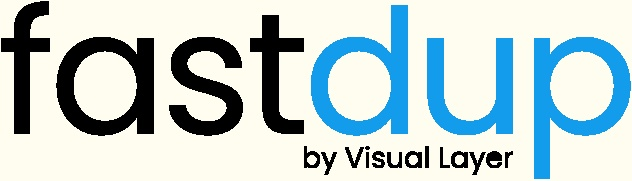
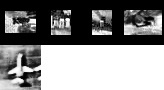
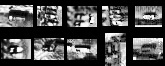
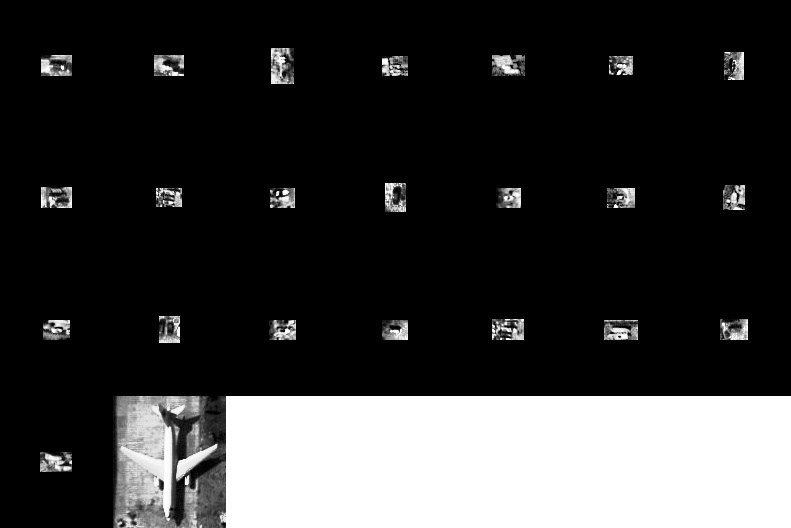

0

In [13]:
fd.vis.component_gallery(load_crops=True, enhance_image=True, keep_aspect_ratio=True, 
                         slice='diff', num_images=20, save_artifacts=True)

Looking at the raw cluster to link back cluster name to to file

In [14]:
df = pd.read_csv('output/galleries/components.csv')

In [15]:
df.head()

Unnamed: 0  component_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     files                                                                                                                                                                        label  \
0          45            45                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            ['output/crops/images126_0_5120.tiff_704_1078_710_1079_709_1091_703_1091.jpg', 'output/crops/images126_0_5120.tiff_991_1081_1004_1081_1004_1086_991_1086.jpg']                                                                                                                                           ['medium_vehicle', 'small_vessel']   
1          59            59                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          ['output/crops/images126_0_5120.tiff_241_1265_259_1265_259_1273_241_1273.jpg', 'output/crops/images126_0_5120.tiff_1166_1005_1181_1005_1181_1009_1166_1010.jpg']                                                                                                                                          ['medium_vehicle', 'medium_vessel']   
2          63            63                                                                                                                                                                                                                                                                                                                                                                                                                   ['output/crops/images126_1280_5120.tiff_996_134_1012_134_1012_141_996_141.jpg', 'output/crops/images126_1280_5120.tiff_192_81_197_80_197_91_193_91.jpg', 'output/crops/images126_1280_5120.tiff_191_101_196_101_196_111_191_111.jpg', 'output/crops/images126_1280_5120.tiff_1012_148_1030_161_1024_170_1006_156.jpg', 'output/crops/images126_1280_5120.tiff_909_1133_909_1107_939_1107_939_1132.jpg']                                                                                 ['heavy_equipment', 'medium_vehicle', 'medium_vehicle', 'heavy_equipment', 'small_aircraft']   
3          

Looking at good labels

In [16]:
fd.vis.component_gallery(load_crops=True, enhance_image=True, keep_aspect_ratio=True,
                         slice='same', num_images=20, save_artifacts=True)

Traceback (most recent call last):
  File "/home/dnth/anaconda3/envs/fastdup/lib/python3.10/site-packages/fastdup/__init__.py", line 1376, in create_components_gallery
    ret = do_create_components_gallery(work_dir, save_path, num_images, lazy_load, get_label_func, group_by, slice,
  File "/home/dnth/anaconda3/envs/fastdup/lib/python3.10/site-packages/fastdup/galleries.py", line 1399, in do_create_components_gallery
    ret = visualize_top_components(work_dir, save_dir, num_images,
  File "/home/dnth/anaconda3/envs/fastdup/lib/python3.10/site-packages/fastdup/galleries.py", line 795, in visualize_top_components
    top_components = do_find_top_components(work_dir=work_dir, get_label_func=get_label_func, group_by=group_by,
  File "/home/dnth/anaconda3/envs/fastdup/lib/python3.10/site-packages/fastdup/galleries.py", line 1236, in do_find_top_components
    assert len(comps), "No components found with more than one image/video"
AssertionError: No components found with more than one image

## Outliers

Let's look on outliers on the satellite image level

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 26144.37it/s]

Stored outliers visual view in  output/galleries/outliers.html



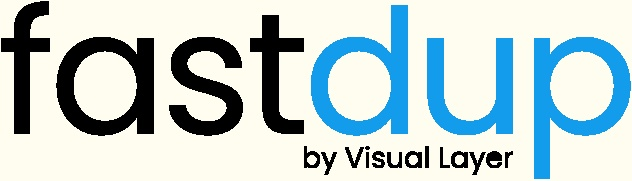
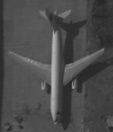
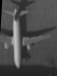
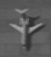

0

In [17]:
fd.vis.outliers_gallery()

Now we look at outliers at the crop level

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 17445.11it/s]

Stored outliers visual view in  output/galleries/outliers.html



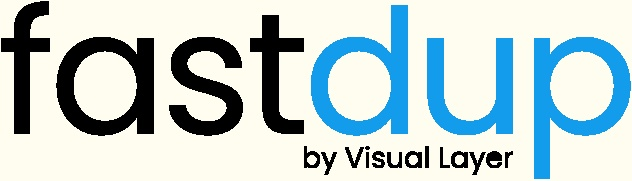
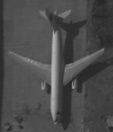
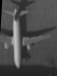
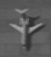

0

In [18]:
fd.vis.outliers_gallery(load_crops=True)

## Brightest Image

We look for the brightest satellite images

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 6562.32it/s]

Stored mean visual view in  output/galleries/mean.html



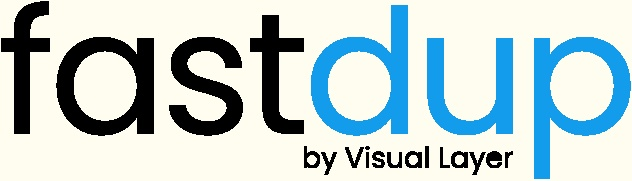
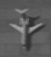
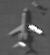
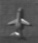
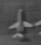
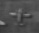
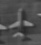

0

In [19]:
fd.vis.stats_gallery(metric='mean')

## Blurry Images 
Now we look for the most blurry images

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 6341.55it/s]


Stored blur visual view in  output/galleries/blur.html



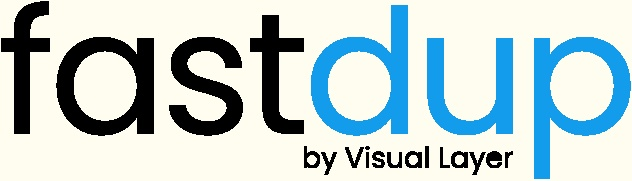

0

In [20]:
fd.vis.stats_gallery(metric='blur',load_crops=True)

## Wrap Up

Next, feel free to check out other tutorials -

+ ⚡ [**Quickstart**](https://nbviewer.org/github/visual-layer/fastdup/blob/main/examples/quick-dataset-analysis.ipynb): Learn how to install fastdup, load a dataset and analyze it for potential issues such as duplicates/near-duplicates, broken images, outliers, dark/bright/blurry images, and view visually similar image clusters. If you're new, start here!
+ 🧹 [**Clean Image Folder**](https://nbviewer.org/github/visual-layer/fastdup/blob/main/examples/cleaning-image-dataset.ipynb): Learn how to analyze and clean a folder of images from potential issues and export a list of problematic files for further action. If you have an unorganized folder of images, this is a good place to start.
+ 🖼 [**Analyze Image Classification Dataset**](https://nbviewer.org/github/visual-layer/fastdup/blob/main/examples/analyzing-image-classification-dataset.ipynb): Learn how to load a labeled image classification dataset and analyze for potential issues. If you have labeled ImageNet-style folder structure, have a go!
+ 🎁 [**Analyze Object Detection Dataset**](https://nbviewer.org/github/visual-layer/fastdup/blob/main/examples/analyzing-object-detection-dataset.ipynb): Learn how to load bounding box annotations for object detection and analyze for potential issues. If you have a COCO-style labeled object detection dataset, give this example a try.


## VL Profiler
If you prefer a no-code platform to inspect and visualize your dataset, [**try our free cloud product VL Profiler**](https://app.visual-layer.com) - VL Profiler is our first no-code commercial product that lets you visualize and inspect your dataset in your browser. 

[Sign up](https://app.visual-layer.com) now, it's free.

[![image](https://raw.githubusercontent.com/visual-layer/fastdup/main/gallery/vl_profiler_promo.svg)](https://app.visual-layer.com)

As usual, feedback is welcome! 

Questions? Drop by our [Slack channel](https://visualdatabase.slack.com/join/shared_invite/zt-19jaydbjn-lNDEDkgvSI1QwbTXSY6dlA#/shared-invite/email) or open an issue on [GitHub](https://github.com/visual-layer/fastdup/issues).